# Interpret CNN model

In [1]:
# default_exp interp.visual

In [59]:
# export
from typing import Callable, List, Dict
from forgebox.imports import *
import io
from ipywidgets import FileUpload
from torchvision import transforms as tfm
from unpackai.utils import url_2_text

In [105]:
from torchvision.models import resnet18, resnet34

In [6]:
# export
IMAGENET_CLASSES_TEXT = url_2_text(
    "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt")

In [7]:
IMAGENET_CLASSES = eval(IMAGENET_CLASSES_TEXT)

In [8]:
IMAGENET_CLASSES[463]

'bucket, pail'

In [81]:
model = resnet18(pretrained=True, progress=True).eval()
model = resnet(pretrained=True, progress=True).eval()

In [82]:
IMAGES = list(Path("../test/img/Nature/").iterdir())

## Simple Transformation

In [83]:
# export
def simple_to_tensor(
        size: int = 224,
        mean_: List[float] = [0.485, 0.456, 0.406],
        std: List[float] = [0.229, 0.224, 0.225],
        img_transforms: List = [],
        tensor_tranforms: List = [],
        return_batch: bool = False, 
    ) -> Callable:
    trans = tfm.Compose([
        tfm.Resize(size),
        *img_transforms,
        tfm.ToTensor(),
        *tensor_tranforms,
        tfm.Normalize(mean=mean_, std=std)
    ])
    if return_batch:
        def to_tensor(img):
            return trans(img.convert('RGB'))[None,...]
    else:
        def to_tensor(img):
            """
            """
            return trans(img.convert('RGB'))
    return to_tensor

basic_trans = simple_to_tensor(return_batch=True)

In [84]:
# export
def tensor_to_8b(x):
    min_ = x.min()
    max_ = x.max()
    return (256*(x-min_)/(max_-min_)).astype(np.int8)

In [85]:
# export
def get_features_resnet(self, x):
    # See note [TorchScript super()]
    with torch.no_grad():
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

In [97]:
# export

def plot_contrary_overlap(
    image1: Image,
    image2: Image,
    image2_overlap: Image,
    colormap: str = 'hot'
) -> None:
    """
    compare image1 with image2+image2_overlap
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax2.imshow(image2, alpha=.5,)
    hm = ax2.imshow(image2_overlap.resize((image2.width, image2.height)),
                    alpha=.5, cmap=colormap)
    ax1.imshow(image1,)
    plt.show()


def visualize_conv_backbone(
    model: nn.Module,
    img: Image,
    classes_map: Dict[int,str] = IMAGENET_CLASSES,
    model_type: str = "resnet",
):
    """
    Visualize convolutional model backbone
    """
    # all model pipeline
    get_features_funcs = dict(
        resnet=get_features_resnet
    )
    # check if the model type supported
    if model_type not in get_features_funcs:
        raise KeyError(f"'{model_type}' not supported" +
                       f"\nmodel_type should be one of " +
                       "{list(get_features_funcs.keys())}")

    get_features = get_features_funcs[model_type]

    # make sure model is in cpu
    model.cpu()
    model.eval()
    display(img.resize((224, 224)))
    tensor = basic_trans(img)

    with torch.no_grad():
        y_ = model(tensor)[0]
    features = get_features(model, tensor)[0]

    significance = y_.argsort().flip(dims=(0,)).numpy()

    significance_df = pd.DataFrame(dict(
        name=list(map(classes_map.get, significance)),
        idx=significance,
        pred=y_.cpu().reshape(-1).numpy()[significance]
    ))
    significance_df.paginate()
    first_cls = significance_df.iloc[0, 0]

    @interact
    def search_kw(kw=first_cls):
        sub_df = significance_df[
            significance_df.name.str.contains(kw)]
        if len(sub_df) < 0:
            print(f"no such class '{kw}'")
        elif len(sub_df) == 1:
            cls = sub_df.to_dict(orient="records")[0]
            cls_name = cls['name']
            idx = cls['idx']
            print(f"{cls_name}(class #{idx})\tselected")
            with torch.no_grad():
                feature_importance = model.fc.weight.data[
                    idx][:, None, None]*features

                feature_rank = feature_importance\
                    .sum(-1).sum(-1).argsort().flip(dims=(0,))
            def visualize_a_feature()
            feature_idx = feature_rank[0]
            print(
                "Visualizing Most Contributing Feature Channel:" +
                f"#{feature_idx}/total {len(feature_rank)}")
            overlap_image = Image.fromarray(tensor_to_8b(
                feature_importance[feature_idx, ...].numpy()),
                mode="L")
            plot_contrary_overlap(img, img,
                                  overlap_image)

        else:
            display(sub_df.head())

In [98]:
# export
def image_upload(
    callback: Callable,
    show_image: bool = True
):
    """
    Upload image
    to put image through a specific callback
    """
    fileupload = FileUpload()
    def after_upload(o):
        for name, file_info in fileupload.value.items():
            try:
                # try to open the uploaded file string as image
                img = Image.open(io.BytesIO(file_info['content']))
                if show_image:
                    display(img)
                # excute the follow up stage upon image upload
                callback(img)
            except OSError as e:
                Print("The uploaded file is not a valid image")
                return

    fileupload.observe(after_upload, names='_counter')

    display(fileupload)

In [99]:
def visualize_conv_backbone_upload(img, ):
    visualize_conv_backbone(model, img, model_type="resnet")

FileUpload(value={}, description='Upload')

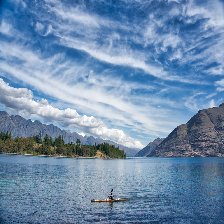

interactive(children=(IntSlider(value=25, description='page', max=50), Output()), _dom_classes=('widget-intera…

interactive(children=(Text(value='lakeside, lakeshore', description='kw'), Output()), _dom_classes=('widget-in…

In [104]:
image_upload(visualize_conv_backbone_upload, show_image=False)

In [95]:
@interact
def visualize_conv_backbone_(image_path=IMAGES):
    with Image.open(image_path) as img:
        visualize_conv_backbone(model, img, model_type="resnet")

interactive(children=(Dropdown(description='image_path', options=(PosixPath('../test/img/Nature/007_9554a747.j…